# Installation

In [ ]:
! pip install tweepy
! pip install python-dotenv
! pip install -U textblob
! pip install nltk
! pip install -U spacy
! pip install wordcloud
# python -m spacy download en_core_web_sm

     --------------------------------------- 12.2/12.2 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.0
    Uninstalling spacy-3.5.0:
      Successfully uninstalled spacy-3.5.0
     -------------------------------------- 153.1/153.1 kB 4.5 MB/s eta 0:00:00


# Import necessary libraries

In [ ]:
import tweepy
from textblob import TextBlob
import pandas as pd
from dotenv import load_dotenv
import os
import csv
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from wordcloud import WordCloud

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sadiq\AppData\Roaming\nltk_data...


True

# Twitter API

In [ ]:
load_dotenv()

True

In [ ]:
consumer_key = os.environ["API_KEY"]
consumer_secret = os.environ["API_KEY_SECRET"]
access_token = os.environ["ACCESS_TOKEN"]
access_secret = os.environ["ACCESS_TOKEN_SECRET"]

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)


# Data Collection

### Search tweets

In [ ]:
# List of queries
queries = ['Technology Innovation UAE', 'Meta Verse UAE', 'Technology Footprint in UAE', 
           'Artificial Intelligence UAE', 'Museum of the Future Dubai', 'Autonomous cars UAE',
           'Expo 2020','ChatGPT UAE', 'Solar power UAE', 'Automation UAE',
           'Robotics UAE', 'Machine learning UAE', 'Abu Dhabi G42', 'Neurotechnology UAE', 'Self driving UAE',
           'Emirates Lunar Mission', 'UAE Hackathon', 'UAE Moon', 'Women in Tech UAE', 'Police drones UAE',
           'Self driving taxi UAE', 'codershq', 'UAE space', 'Dubai smart city', 'AI office UAE', 'Emirates airlines',
           'Dubai airport', 'Renewable energy UAE']

# Collect tweets
tweets = []
for query in queries:
    full_query = f"{query} -filter:retweets"
    cursor = tweepy.Cursor(api.search, q=full_query, lang='en', tweet_mode='extended').items(500)
    for tweet in cursor:
        tweets.append(tweet.full_text)

In [ ]:
# total no. of tweets retrieved.
len(tweets)

2099

In [ ]:
# first 5 tweets
tweets[:5]

["It's great to see  President of Poland, Mr. Andrzej Duda, taking an interest in Masdar City , a hub for sustainable technology and innovation.\n#Masdar #uae #poland #uaePoland https://t.co/nYuTNJ6DKb",
 "Great to see #UAE continued efforts to foster #innovation  and technology! HH Sheikh Khaled bin Mohamed's meeting with @Microsoft  Vice Chair &amp; President shows the country's commitment to digital transformation and #collaboration  with global leaders. https://t.co/sGc492VkH3",
 'Just in: HH Sheikh Khaled bin Mohamed bin Zayed Al Nahyan meets with Microsoft Vice Chair &amp; President @BradSmi in #AbuDhabi, discussing the exciting potential of technology to drive growth and innovation in the #UAE. #Microsoft #partnership https://t.co/gdgm23N3OH',
 'Joining forces for #innovation!\n The Emirates Group hosts #FORSA_TEK - an annual event that brings together Intelak, Aviation X Lab, #startups, industry majors &amp; key technology partners to create new opportunities in #aviation. Exci

### Store tweets into csv - only write once (first time)

In [ ]:
f = open("tweets2.csv", "a")
writer = csv.writer(f)
for tweet in tweets:
    writer.writerow([tweet])
f.close()

# Text preprocessing - Tokenizing, Removing stop words, punctuations, URLs and twitter mentions

### Function to process the tweets

In [ ]:
# Download necessary tools from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Define stop words
stop_words = set(stopwords.words('english'))

# Define regular expression for removing punctuation
punct_pattern = re.compile(r'[^\w\s]')

# Define regular expression for removing URLs and mentions
url_pattern = re.compile(r'https?://\S+|www\.\S+')
mention_pattern = re.compile(r'@[A-Za-z0-9_]+')

# Define function to perform text processing
def process_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = url_pattern.sub('', text)

    # Remove user mentions
    text = mention_pattern.sub('', text)

    # remove numbers
    text = ''.join((z for z in text if not z.isdigit()))
    
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove punctuation
    tokens = [punct_pattern.sub('', token) for token in tokens]
    
    # Remove any remaining empty tokens
    tokens = [token for token in tokens if token]

    # Join tokens back into a single string
    text_processed = ' '.join(tokens)
    
    return text_processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sadiq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sadiq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Testing if preprocess works

In [ ]:
# Original tweet
tweets[0]

"It's great to see  President of Poland, Mr. Andrzej Duda, taking an interest in Masdar City , a hub for sustainable technology and innovation.\n#Masdar #uae #poland #uaePoland https://t.co/nYuTNJ6DKb"

In [ ]:
# Processed tweet
process_text(tweets[0])

's great see president poland mr andrzej duda taking interest masdar city hub sustainable technology innovation masdar uae poland uaepoland'

### Preprocess all tweets

In [ ]:
# Process all tweets
process_tweets = []
for tweet in tweets:
    process_tweets.append(process_text(tweet))

# Data labelling - Sentiment Analysis

##### Print top 5 tweets belonging to - Positive, Neutral and Negative categories based on their sentiment scores on processed tweets

In [ ]:
topPos = {}
topNeu = {}
topNeg = {}

for tweet in process_tweets:
    analysis = TextBlob(tweet)
    if len(topPos) < 5:
        if(analysis.sentiment.polarity > 0.8):
            topPos[analysis.sentiment.polarity] = tweet
    if len(topNeu) < 5:
        if(analysis.sentiment.polarity >= -0.2 and analysis.sentiment.polarity <= 0.2):
            topNeu[analysis.sentiment.polarity] = tweet
    if len(topNeg) < 5:
        if(analysis.sentiment.polarity < -0.5):
            topNeg[analysis.sentiment.polarity] = tweet


# Sorting positive top 5 list
tempKeys = list(topPos.keys())
tempKeys.sort(reverse = True)
sorted_dict = {i: topPos[i] for i in tempKeys}
 
topPos = sorted_dict

# Sorting neutral top 5 list
tempKeys = list(topNeu.keys())
tempKeys.sort(reverse = True)
sorted_dict = {i: topNeu[i] for i in tempKeys}
 
topNeu = sorted_dict

# Sorting negative top 5 list
tempKeys = list(topNeg.keys())
tempKeys.sort(reverse = True)
sorted_dict = {i: topNeg[i] for i in tempKeys}
 
topNeg = sorted_dict


print("TOP 5 POSITIVE: ")
print(" ")
for i in topPos.keys():
    print("%.2f" % i,": ", topPos[i])
    print('')

print('----------------------------------------')
print(" ")
print("TOP 5 NEUTRAL: ")
print(" ")
for i in topNeu.keys():
    print("%.2f" % i,": ", topNeu[i])
    print('')
print('----------------------------------------')

print(" ")
print("TOP 5 NEGATIVE: ")
print(" ")
for i in topNeg.keys():
    print("%.2f" % i,": ", topNeg[i])
    print('')


TOP 5 POSITIVE: 
 
1.00 :  abu dhabi airport named world best arrival read socialkandura abudhabiairport abudhabi dubainews dubai mydubai dubailife localnews breakingnews citynews regionalnews localupdates localstories localheadlines

0.90 :  also flew via world best airlines qatar airways fly emirates

0.88 :  wishing emirati astronaut sultan al neyadi best upcoming 6month space mission part xspace crew6 team remarkable achievement highlights uae s commitment space exploration innovation uae spacemission nasa سلطان_النيادي crew6

0.85 :  dubai landing dubai quite beautiful airport

0.85 :  hi strongly recommend make cards magnificent features see people shifting airlines emirates also ccs banks attractive best card best banking

----------------------------------------
 
TOP 5 NEUTRAL: 
 
0.20 :  uae s emirates airlines introduces world s firstever robotic checkin system airports innovative technology set transform air travel experience making faster efficient passengers roboticchecki

### Updating csv to contain sentiment scores for each tweet

In [ ]:
# Create variables to hold the average polarity
positive = 0
negative = 0
neutral = 0
polarity = 0

In [ ]:
f = open("tweets2.csv", "a")
writer = csv.writer(f)
writer.writerow(['Tweets', 'Sentiment'])


for tweet in tweets:
    analysis = TextBlob(process_text(tweet)) 
    polarity += analysis.sentiment.polarity
   
    if(analysis.sentiment.polarity == 0):
        neutral += 1
        writer.writerow([tweet, 0])
       
    elif(analysis.sentiment.polarity < 0.00):
        negative += 1
        writer.writerow([tweet, -1])

    elif(analysis.sentiment.polarity > 0.00):
        positive += 1
        writer.writerow([tweet, 1])

f.close()


### Visualize number of tweets belonging to Positive, Neutral and Negative sentiments

In [ ]:
## Define a function to calculate the percentage ##
def percentage(part, whole):
    return 100 * float(part)/float(whole)

positive = percentage(positive, len(process_tweets))
negative = percentage(negative, len(process_tweets))
neutral  = percentage(neutral, len(process_tweets))
polarity  = percentage(polarity, len(process_tweets))

# Limit the decimal upto 2 places #
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')


In [ ]:
print("How people are reacting on Technology and Innovation in UAE" + 
      " By analyzing " + str(len(process_tweets)) + " Tweets ")

if (polarity == 0):
    print("Neutral")
    
elif (polarity < 0.00):
    print("Negative")
    
elif (polarity > 0.00):
    print("Positive")

How people are reacting on Technology and Innovation in UAE By analyzing 2099 Tweets 
Positive


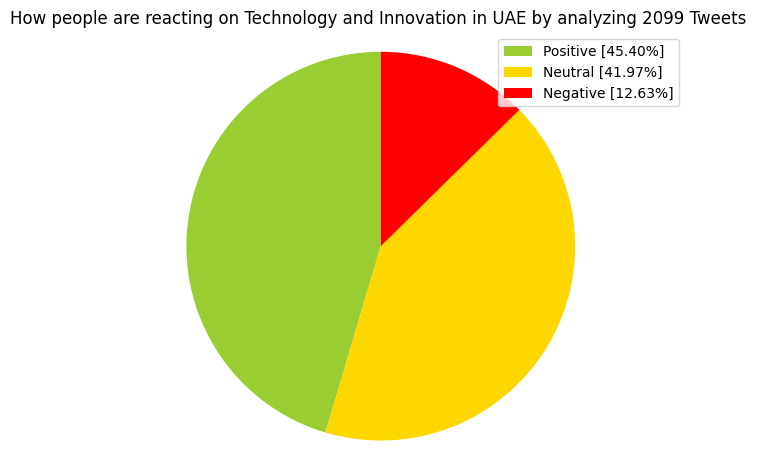

In [ ]:
## Print the Pie Chart ##
    
labels = ['Positive ['+str(positive)+'%]', 
          'Neutral ['+str(neutral)+'%]', 
          'Negative ['+str(negative)+'%]']

sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'gold', 'red']
patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.legend(patches, labels, loc = "best")
plt.title("How people are reacting on Technology and Innovation in UAE" + 
      " by analyzing " + str(len(process_tweets)) + " Tweets ")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Text analytics pipeline

### Load data from csv

In [ ]:
df = pd.read_csv('tweets2.csv')

df.head()

,Tweets,Sentiment
0,NaN,NaN
1,"It's great to see President of Poland, Mr. An...",1.0
2,NaN,NaN
3,Great to see #UAE continued efforts to foster ...,1.0
4,NaN,NaN


### Remove Nan values

In [ ]:
df = df.dropna()

df.head()

,Tweets,Sentiment
1,"It's great to see President of Poland, Mr. An...",1.0
3,Great to see #UAE continued efforts to foster ...,1.0
5,Just in: HH Sheikh Khaled bin Mohamed bin Zaye...,1.0
7,Joining forces for #innovation!\r\n The Emirat...,1.0
9,Are you looking for a trustworthy and reliable...,1.0


### Store tweets and labels in two different variables

In [ ]:
X = df['Tweets']
X.head()

1    It's great to see  President of Poland, Mr. An...
3    Great to see #UAE continued efforts to foster ...
5    Just in: HH Sheikh Khaled bin Mohamed bin Zaye...
7    Joining forces for #innovation!\r\n The Emirat...
9    Are you looking for a trustworthy and reliable...
Name: Tweets, dtype: object

In [ ]:
y = df['Sentiment']
y.head()

1    1.0
3    1.0
5    1.0
7    1.0
9    1.0
Name: Sentiment, dtype: float64

### Split data into training and testing (80%-20% split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X)

2099

In [ ]:
len(X_train)

1679

In [ ]:
len(X_test)

420

### Remove URLs, punctuations, stop words

In [ ]:
process_train = []
for tweet in X_train:
    process_train.append(process_text(tweet))

### Normalization - Stemming

In [ ]:
stemmer = SnowballStemmer('english')
normalized_process_train_stem = []

for tweet in process_train:
    
    # Tokenize text
    tokens = nltk.word_tokenize(tweet)
        
    # Stem words
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Remove any remaining empty tokens
    tokens = [token for token in tokens if token]

    # Join tokens back into a single string
    text_processed = ' '.join(tokens)

    normalized_process_train_stem.append(text_processed)

### Normalizing - Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
normalized_process_train = []
for tweet in process_train:
    
    # Tokenize text
    tokens = nltk.word_tokenize(tweet)
        
    # Stem words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove any remaining empty tokens
    tokens = [token for token in tokens if token]

    # Join tokens back into a single string
    text_processed = ' '.join(tokens)

    normalized_process_train.append(text_processed)

### Comparison between Stemming and Lemmatization

In [ ]:
# Entire first tweet
X_train.iloc[0]

'I want to fly with a woman who thinks of me.....\r\n🌍✈️👨\u200d✈️ \r\n#pilot #ariport #airlines #hostess \r\n@BoeingAirplanes\r\n\r\n@Airbus\r\n\r\n@TurkishAirlines\r\n\r\n@airfrance\r\n\r\n@emirates\r\n\r\n@KLM\r\n\r\n@Qantas\r\n\r\n@SpiritAirlines\r\n\r\n@lufthansa https://t.co/ws32Kh3HI8'

In [ ]:
# First tweet after removing stop words, punctuation, links
process_train[0]

'want fly woman thinks pilot ariport airlines hostess'

In [ ]:
# first tweet after processing and stemming
normalized_process_train_stem[0]

'want fli woman think pilot ariport airlin hostess'

In [ ]:
# first tweet after processing and lemmatization
normalized_process_train[0]

# Since lemmatization preserves the overall meaning of the sentence, we chose it for our normalization technique.

'want fly woman think pilot ariport airline hostess'

### Bag of words representation

In [ ]:
# CountVectorizer object
vect =  CountVectorizer(min_df=15) 
vect.fit(normalized_process_train)
print("Vocabulary size: {}".format(len(vect.vocabulary_)))

Vocabulary size: 331


In [ ]:
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary content:
 {'want': 320, 'fly': 101, 'woman': 325, 'think': 298, 'airline': 12, 'emirate': 82, 'amp': 19, 'philippine': 216, 'reveal': 237, 'interline': 135, 'deal': 69, 'passenger': 213, 'connectivity': 59, 'aviation': 32, 'abudhabi': 1, 'solar': 263, 'power': 223, 'facility': 96, 'plant': 219, 'supply': 285, 'gw': 118, 'system': 288, 'demand': 70, 'uae': 311, 'march': 172, 'aribau': 25, 'multicines': 185, 'barcelona': 35, 'spain': 270, 'space': 266, 'odeon': 199, 'milan': 176, 'italy': 141, 'national': 188, 'theatre': 295, 'abu': 0, 'dhabi': 74, 'kathryn': 146, 'daniel': 65, 'joshua': 144, 'zanjoe': 330, 'series': 250, 'ootc': 206, 'show': 256, 'coming': 55, 'get': 108, 'ticket': 299, 'theme': 296, 'international': 136, 'day': 68, 'top': 302, 'airport': 13, 'seat': 244, 'month': 182, 'world': 327, 'based': 36, 'dubai': 75, 'energy': 84, 'great': 117, 'middle': 175, 'east': 78, 'flight': 100, 'number': 198, 'ek': 81, 'lhr': 155, 'london': 161, 'heathrow': 120, 'dxb': 76, 'de

In [ ]:
bag_of_words = vect.transform(normalized_process_train)
bag_of_words

<1679x331 sparse matrix of type '<class 'numpy.int64'>'
	with 14086 stored elements in Compressed Sparse Row format>

In [ ]:
print("Dense representation of bag_of_words:\n{}".format(bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

### Binary representation

In [ ]:
vectorizer = CountVectorizer(binary=True, min_df=15)

# Fit the vectorizer to the data
binary_representation = vectorizer.fit_transform(normalized_process_train)

# Convert the sparse matrix to a dense matrix and print the output
df = pd.DataFrame(binary_representation.todense(), columns=vectorizer.get_feature_names_out())
print(df)

      abu  abudhabi  achievement  across  adsbexchange  adx  agency  \
0       0         0            0       0             0    0       0   
1       0         0            0       0             0    0       0   
2       0         1            0       0             0    0       0   
3       1         0            0       0             0    0       0   
4       1         0            0       0             0    0       0   
...   ...       ...          ...     ...           ...  ...     ...   
1674    1         0            0       0             0    0       0   
1675    0         0            0       0             0    0       0   
1676    0         0            0       0             0    0       0   
1677    0         0            0       0             0    0       0   
1678    0         0            0       0             0    0       0   

      agreement  ai  air  ...  watch  way  week  well  woman  work  world  \
0             0   0    0  ...      0    0     0     0      1     0    

### Tf-idf representation

In [ ]:
vectorizer = TfidfVectorizer(min_df=15)

tfidf_representation = vectorizer.fit_transform(normalized_process_train)

# Convert the sparse matrix to a dense matrix and print the output
df = pd.DataFrame(tfidf_representation.todense(), columns=vectorizer.get_feature_names_out())
print(df)

           abu  abudhabi  achievement  across  adsbexchange  adx  agency  \
0     0.000000  0.000000          0.0     0.0           0.0  0.0     0.0   
1     0.000000  0.000000          0.0     0.0           0.0  0.0     0.0   
2     0.000000  0.198553          0.0     0.0           0.0  0.0     0.0   
3     0.197547  0.000000          0.0     0.0           0.0  0.0     0.0   
4     0.141620  0.000000          0.0     0.0           0.0  0.0     0.0   
...        ...       ...          ...     ...           ...  ...     ...   
1674  0.227768  0.000000          0.0     0.0           0.0  0.0     0.0   
1675  0.000000  0.000000          0.0     0.0           0.0  0.0     0.0   
1676  0.000000  0.000000          0.0     0.0           0.0  0.0     0.0   
1677  0.000000  0.000000          0.0     0.0           0.0  0.0     0.0   
1678  0.000000  0.000000          0.0     0.0           0.0  0.0     0.0   

      agreement   ai  air  ...  watch  way  week  well    woman  work  world  \
0      

c:\Users\sadiq\anaconda3\envs\tensorProject\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Evaluation and comparison of classifiers

##### Text processing

In [ ]:
process_X = []
for tweet in X:
    process_X.append(process_text(tweet))

In [ ]:
lemmatizer = WordNetLemmatizer()
normalized_process_X = []
for tweet in process_X:
    
    # Tokenize text
    tokens = nltk.word_tokenize(tweet)
        
    # Stem words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove any remaining empty tokens
    tokens = [token for token in tokens if token]

    # Join tokens back into a single string
    text_processed = ' '.join(tokens)

    normalized_process_X.append(text_processed)

##### Tf-idf vectorization

In [ ]:
# Vectorize test data too
vectorizer = TfidfVectorizer(min_df=15)

tfidf_representation_X = vectorizer.fit_transform(normalized_process_X)

# Convert the sparse matrix to a dense matrix and print the output
df = pd.DataFrame(tfidf_representation_X.todense(), columns=vectorizer.get_feature_names_out())
print(df)

      abu  abudhabi  achievement  across  adsb  adsbexchange  adx  agency  \
0     0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
1     0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
2     0.0  0.232661          0.0     0.0   0.0           0.0  0.0     0.0   
3     0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
4     0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
...   ...       ...          ...     ...   ...           ...  ...     ...   
2094  0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
2095  0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
2096  0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
2097  0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   
2098  0.0  0.000000          0.0     0.0   0.0           0.0  0.0     0.0   

      agreement        ai  ...  week  well  went  woman  work  world  worth

c:\Users\sadiq\anaconda3\envs\tensorProject\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_representation_X, y, test_size=0.2, random_state=42)

##### Logistic regression

In [ ]:
# Train and evaluate a logistic regression classifier
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
precision_lr = precision_score(y_test, lr_pred, average='macro')
recall_lr = recall_score(y_test, lr_pred, average='macro')
f1_lr = f1_score(y_test, lr_pred, average='macro')

In [ ]:
print('Logistic Regression: ')
print('Precision: {:.2f}'.format(precision_lr))
print('Recall: {:.2f}'.format(recall_lr))
print('F1-score: {:.2f}'.format(f1_lr))

Logistic Regression: 
Precision: 0.75
Recall: 0.66
F1-score: 0.69


##### Support Vector Machine (SVM) Classifier

In [ ]:
# Train and evaluate a SVM classifier
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_svm = f1_score(y_test, y_pred_svm, average='macro')

In [ ]:
print('SVM: ')
print('Precision: {:.2f}'.format(precision_svm))
print('Recall: {:.2f}'.format(recall_svm))
print('F1-score: {:.2f}'.format(f1_svm))

SVM: 
Precision: 0.81
Recall: 0.68
F1-score: 0.71


##### Multinomial Naive Bayes

In [ ]:
# Train and evaluate a Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
precision_nb = precision_score(y_test, y_pred_nb, average='macro')
recall_nb = recall_score(y_test, y_pred_nb, average='macro')
f1_nb = f1_score(y_test, y_pred_nb, average='macro')

In [ ]:
print('Naive Bayes: ')
print('Precision: {:.2f}'.format(precision_nb))
print('Recall: {:.2f}'.format(recall_nb))
print('F1-score: {:.2f}'.format(f1_nb))

Naive Bayes: 
Precision: 0.71
Recall: 0.63
F1-score: 0.65


##### Visualize results

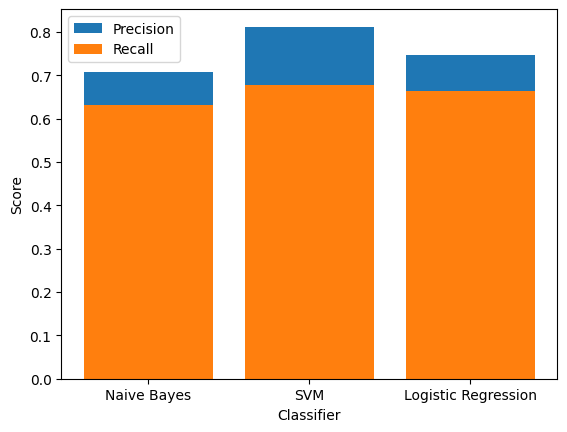

In [ ]:
precision = [precision_nb, precision_svm, precision_lr]
recall = [recall_nb, recall_svm, recall_lr]

plt.bar(['Naive Bayes', 'SVM', 'Logistic Regression'], precision, label='Precision')
plt.bar(['Naive Bayes', 'SVM', 'Logistic Regression'], recall, label='Recall')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.legend()
plt.show()

##### Since SVM has the highest F1-score and shows better result on the graph above, it is the best suitable classifier for us.

# Visualization and Insights from Twitter Sentiment Analysis

### Data distribution

In [ ]:
tweets = pd.read_csv('tweets2.csv')
tweets = tweets.dropna()

In [ ]:
positive_tweets = tweets[tweets['Sentiment'] ==  1.0]
neutral_tweets = tweets[tweets['Sentiment'] ==  0.0]
negative_tweets = tweets[tweets['Sentiment'] ==  -1.0]

In [ ]:
print('Total No. of tweets: {:.2f}'.format(len(tweets['Tweets'])))
print('No. of positive tweets: {:.2f}'.format(len(positive_tweets)))
print('No. of neutral tweets: {:.2f}'.format(len(neutral_tweets)))
print('No. of negative tweets: {:.2f}'.format(len(negative_tweets)))

Total No. of tweets: 2099.00
No. of positive tweets: 953.00
No. of neutral tweets: 881.00
No. of negative tweets: 265.00


As you can see above, there are a majority of positive and neutral tweets and very less negative tweets. This is because of the topic 'Technology and Innovation in UAE'. In UAE, many people support the idea of fast growing technology and love to see new innovations. More on this will be discussed below.

### Creating word cloud for each type of sentiment

In [ ]:
positive_tweets_combine = ' '.join(positive_tweets['Tweets'].apply(process_text))
neutral_tweets_combine = ' '.join(neutral_tweets['Tweets'].apply(process_text))
negative_tweets_combine = ' '.join(negative_tweets['Tweets'].apply(process_text))

In [ ]:
positive_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(positive_tweets_combine)
neutral_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(neutral_tweets_combine)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(negative_tweets_combine)

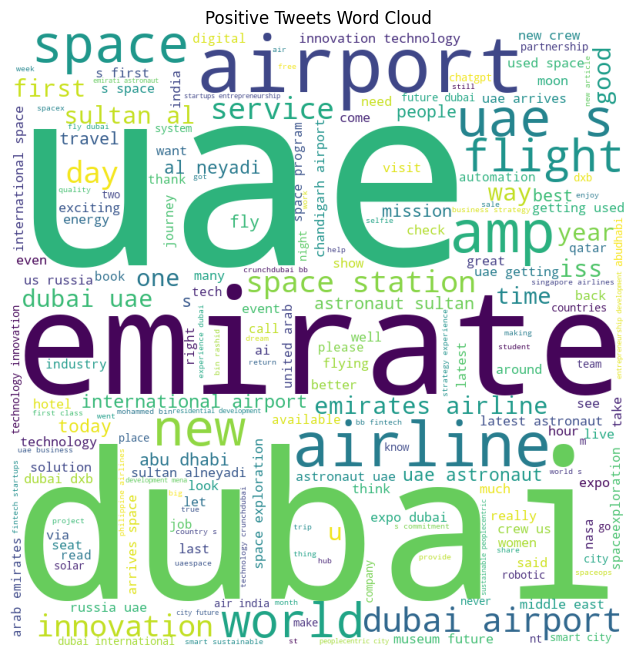

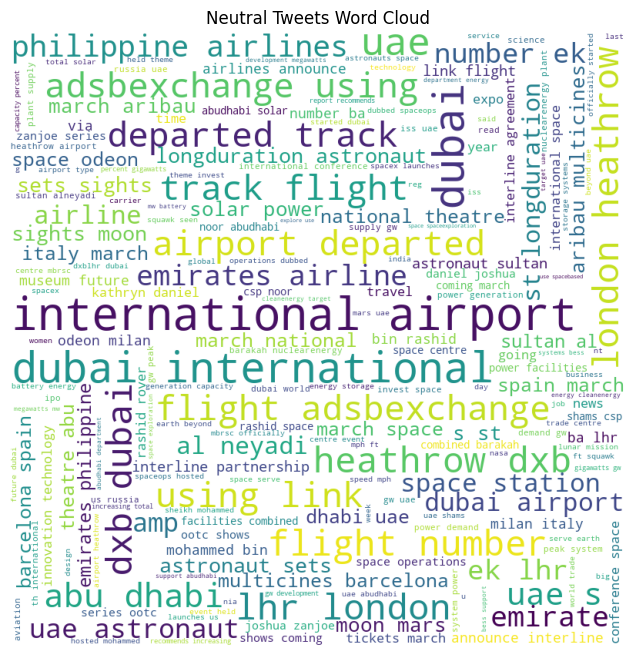

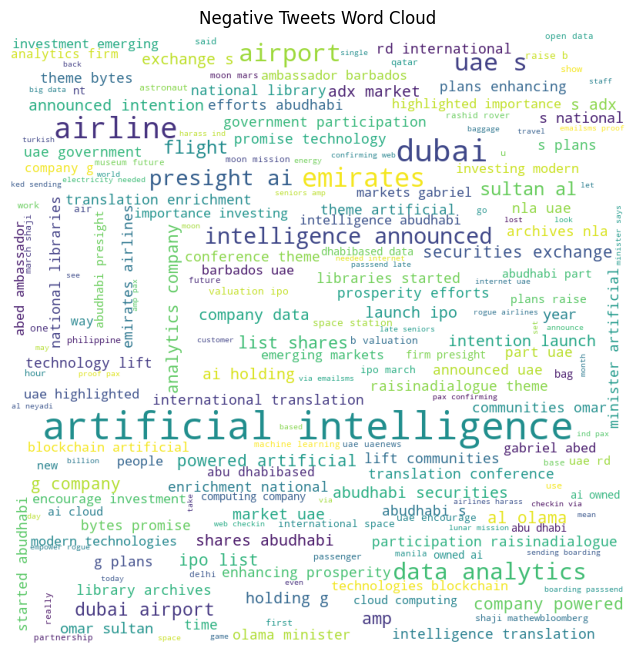

In [ ]:
# display the word clouds

# Positive word cloud
plt.figure(figsize=(8,8))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.title('Positive Tweets Word Cloud')

# Neutral word cloud
plt.figure(figsize=(8,8))
plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.title('Neutral Tweets Word Cloud')


# Negative word cloud
plt.figure(figsize=(8,8))
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.title('Negative Tweets Word Cloud')

plt.show()

Above word clouds show that most of positive tweets are coming from keywords such as Dubai, emirates, airports, robotics, automation and so on.
Whereas, most of the negative tweets come from keywords like artificial intelligence. This is because, with the sudden rise of powerful AI driven tools, there are a lot of misconceptions and fear spread among the general public. Some people believe that AI poses a threat to their jobs and future lives.

# Steps involved in this project

<b>Data collection</b> - Created own dataset by extracting tweets from Twitter using Twitter API. Tweepy was used to regularly extract the tweets. All the tweets are stored in a csv file. A total of 2099 tweets were collected.

<b>Data labelling</b> - First, the tweets were cleaned by tokenizing and remove punctuations, stop words, user mentions, URLs, etc. Then, tweets were labelled according to their sentiment scores (1.0: Positive, 0.0: Neutral, -1.0: Negative). The sentiment scores were found using TextBlob. The csv file was updated to have a new column called 'Sentiment' which had the sentiment score corresponding to each tweet. The pie chart in 'Data Labelling' section shows the distribution of sentiments in the data.

<b>Text Analytics</b> - At first, the data had to be split into 80% training set and 20% test set. The text processing technique was applied again, this time including a normalization like Lemmatization. After this, the data was represented in different ways - Bag of words, Binary representation and TF-IDF. Three classifiers - Logistic Regression, Support Vector Machine (SVM) and Naive Bayes were evaluated on the TF-IDF vectorized data. The SVM classifier turned out to be the best classifier as it had a better F1-score (meaning, better perfomance across all classes). The graph under the 'Evaluation and comparison of classifiers' shows the result.

<b>Visualization</b> - Useful insights and graphs are shown.

# Conclusion

In conclusion, we get an overall positive response from users on Twitter with regards to the topic 'Technology and Innovation in UAE'.<br><br>
We see the rapid growth of technology and innovation in the UAE with a lot of initiatives taken, and at its current rate it has become the central hub in the Middle east. Not only has the UAE appointed an artificial intelligence minister, which is the first country to do so, it also has taken many initiatives like government sponsored research technology and an innovation park. It is also home to a lot of tech startups. UAE also has evolved in the field of renewable and energy and aims to generate 50% of its electricity from renewable sources.<br><br>
We also see the UAE space mission is a very historic event, with UAE's very own astronaut Sultan an-Neyadi being sent on what is to become the longest space mission for someone from an Arab country.<br><br>
And when seen the general consensus on this development is positive, hence the majority positive reception on these and very few negative receptions. And if we look into these negative tweets, we see it is usually the people afraid and pessimistic about the growth of AI and technology.